In [2]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import random as rd
import pickle
import os
from flax import linen as nn
import optax
from flax.training import train_state
from flax.training import checkpoints

2024-11-13 13:30:52.186906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731501052.272099  320893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731501052.289039  320893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
#METODA AUTOGRAD

#Definicja Lagrangianu dla pojedynńczego wahadła liczonego w sposób analityczny
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m   - masa ciała
#  -l   - długość liny
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: wartość Lagrangianu w danym momencie.
def lagrangian_analitical(q, q_t, m, l, g):
    #Eneriga kinetyczna
    Ek=0.5*m*l*jnp.square(q_t)
    
    #Energia potencjalna
    Ep=m*g*(l-l*jnp.cos(q))
    
    #Lagrangian
    return jnp.sum(Ek - Ep)

#Obliczenie energi potencjalnej i kinetycznej układu na podstawie aktualnego stanu
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m   - masa ciała
#  -l   - długość liny
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: 
#  -Ek  - Energia kinetyczna
#  -Ep  - Energia potencjalna
def compute_energy(q, q_t, m, l, g):
    #Eneriga kinetyczna
    Ek=0.5*m*l*jnp.square(q_t)
    
    #Energia potencjalna
    Ep=m*g*(l-l*jnp.cos(q))
    
    #Lagrangian
    return Ek, Ep

#Funkcja ma za zadanie reprezenotwanie równania różniczkowego, wynikającego z rozwiązania
#równanie Eulera-Lagrange'a
#Argumenty funkcji:
#   -lagrangian - Funkcja opisująca Lagrangian. Funkcja musi być typu ,,callable'' żeby,
#                 pochodne Lagrangianu zostały policzone.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości
#   -empty      - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                 koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                 funkcji, ale pozwoli na poprawną kompilację
#Zwracane: Wektor zawiercający przyśpieszenia oraz prędkości w danym momencie.
def equation_of_motion(lagrangian, state, empty=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2)
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = jax.numpy.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
		jax.grad(lagrangian, 0)(q, q_t)
		- jax.jacfwd(jax.grad(lagrangian, 1), 0)(q, q_t) @ q_t)
    return jnp.concatenate([q_t, q_tt])

#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu wyznaczonego
#w sposób analityczny
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m             - masa wahadła
#   -l             - długość liny wahadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m=1, l=1, g=9.8):
  lagrangian = partial(lagrangian_analitical, m=m, l=l, g=g)
  equation = partial(equation_of_motion, lagrangian)
  return odeint(equation, initial_state, times, rtol=1e-10, atol=1e-10)

In [4]:
#METODA ANALICTYCZNA

#Funkcja obliczająca przyśpieszenie wahadła na podstawie aktualnego położenia i prędkości.
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -empty         - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                   koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                   funkcji, ale pozwoli na poprawną kompilację
#   -l             - długość liny wahadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
def analitical(initial_state, empty=None, l=1, g=9.8):
    q = initial_state[0]
    q_t = initial_state[1]
    q_tt = -g / l * jnp.sin(q)
    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

#Funkcja wyznaczająca trajektorię ruchu obliczoną przy użyciu analitycznie wyznaczonego 
# równiania różniczkowego (funkcja analitical)
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -l             - długość liny wahadła
#   -g             - przyśpieszenie ziemskie
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, l=1, g=9.8):
    function = partial(analitical, l=l, g=g)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [5]:
#WYZNACZENIE PUNKTU STARTOWEGO, SZUMU, ORAZ CZASU DLA TESTU POWYŻSZYCH METOD WYZNACZANIA TRAJEKTORI

#Punkt startowy
x0 = jnp.array([0.5,0.2], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x0.size)
#Wektor czasów
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [6]:
#WYZNACZENIE TRAJEKTORI METODĄ AUTOGRAD ORAZ ANALITYCZNĄ

#Autograd
%time autograd_clean = jax.device_get(solve_autograd(x0, t))
#Autograd z małym szumem
%time autograd_noise1 = jax.device_get(solve_autograd(x0 + 1e-10*noise, t))
#Autograd z dużym szumem
%time autograd_noise2 = jax.device_get(solve_autograd(x0 + 1e-2*noise, t))

#Analitycznie
%time analitical_clean = jax.device_get(solve_analitical(x0, t))
#Analitycznie z małym szumem
%time analitical_noise1 = jax.device_get(solve_analitical(x0 + 1e-10*noise, t))
#Analitycznie z dużym szumem
%time analitical_noise2 = jax.device_get(solve_analitical(x0 + 1e-2*noise, t))

CPU times: user 1.69 s, sys: 64.9 ms, total: 1.75 s
Wall time: 1.31 s
CPU times: user 44.2 ms, sys: 758 µs, total: 45 ms
Wall time: 44.9 ms
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 15.4 ms
CPU times: user 897 ms, sys: 15.3 ms, total: 913 ms
Wall time: 532 ms
CPU times: user 9.73 ms, sys: 0 ns, total: 9.73 ms
Wall time: 9.72 ms
CPU times: user 9.17 ms, sys: 0 ns, total: 9.17 ms
Wall time: 9.17 ms


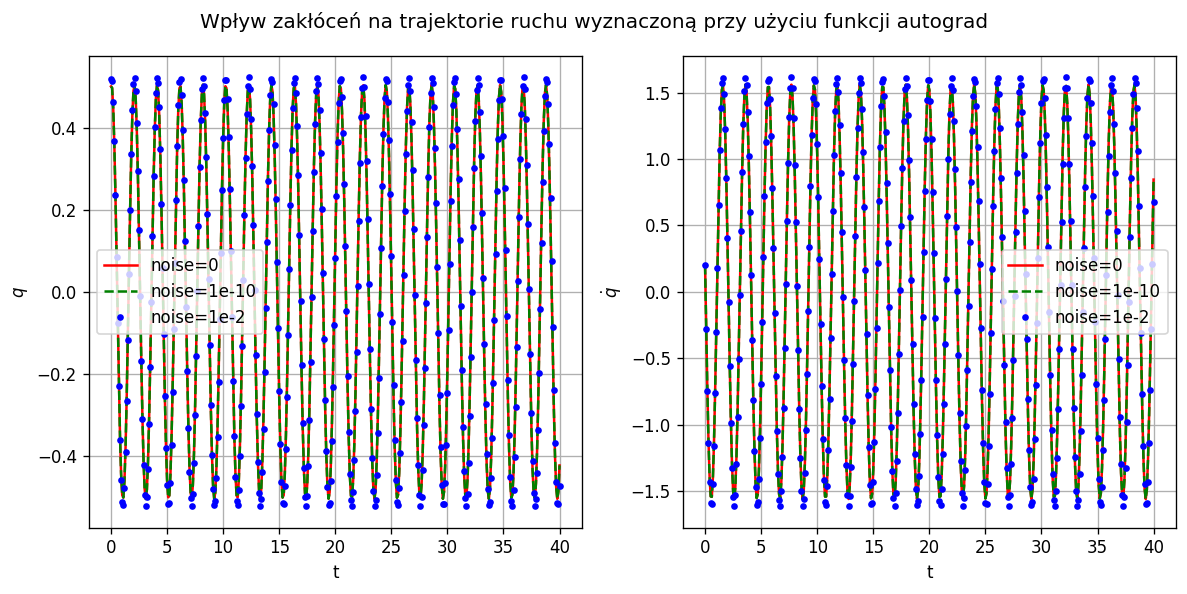

In [7]:
#WYŚWIETLENIE TRAJEKTORI (AUTOGRAD)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu funkcji autograd")

#Położenie (kąt)
axes[0].plot(t, autograd_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, autograd_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, autograd_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, autograd_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, autograd_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, autograd_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].legend()
axes[1].grid()

plt.tight_layout()






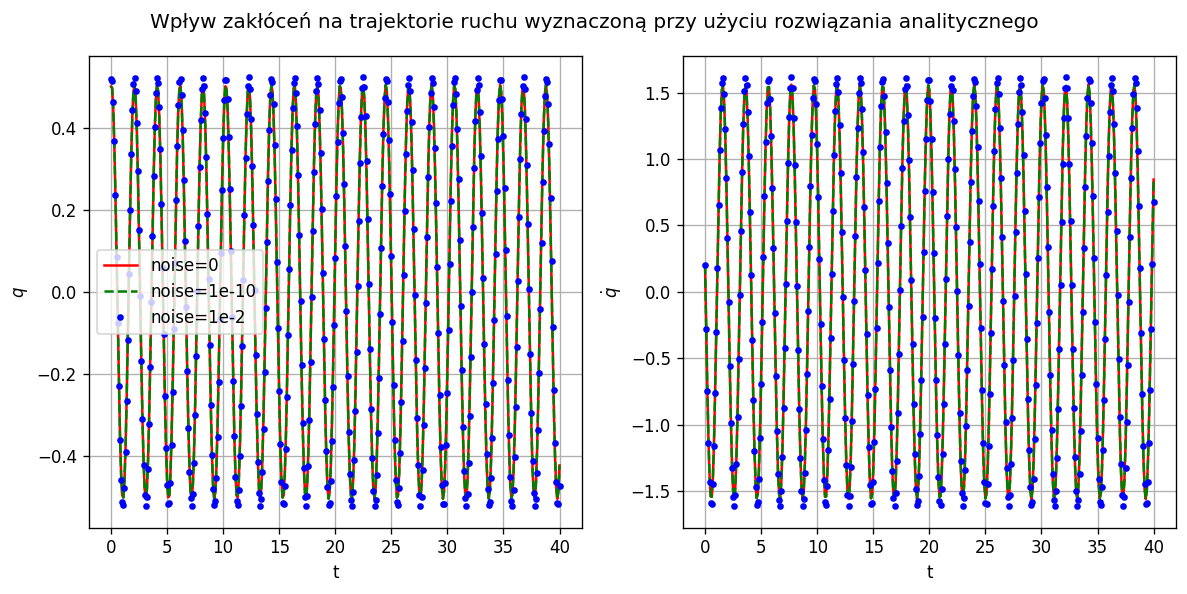

In [8]:
#WYŚWIETLENIE TRAJEKTORI (METODA ANALITYCZNA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu rozwiązania analitycznego')

#Położenie (kąt)
axes[0].plot(t, analitical_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, analitical_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, analitical_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, analitical_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, analitical_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, analitical_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

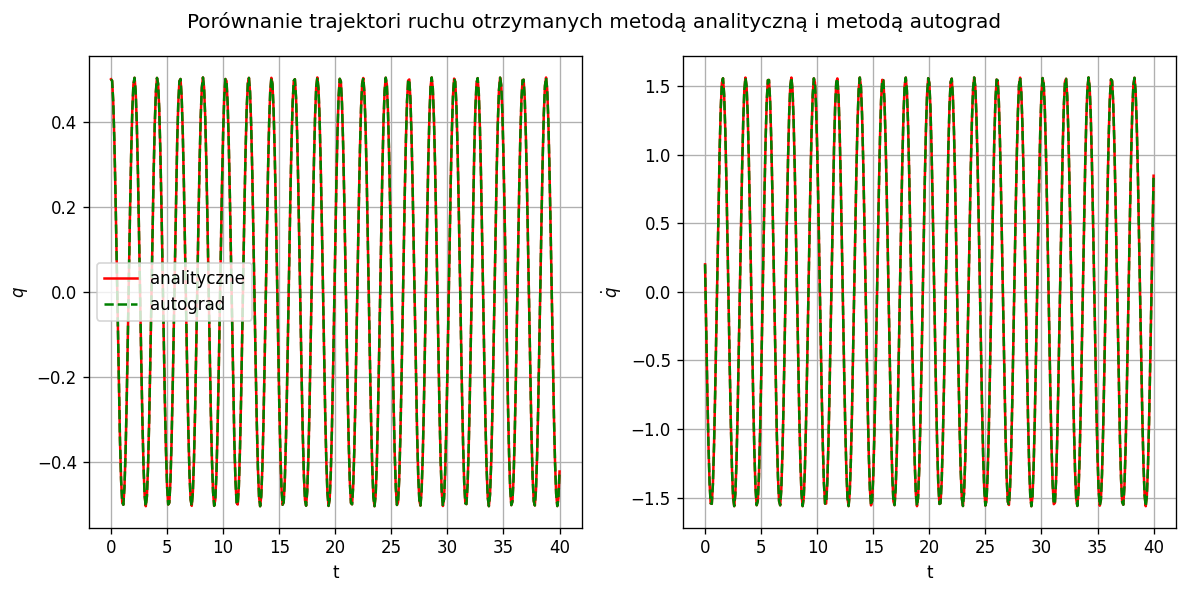

In [9]:
#PORÓWNANIE TRAJEKTORI OTRZYMANYCH PRZY UŻYCIU OBU METOD

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektori ruchu otrzymanych metodą analityczną i metodą autograd')


#Położenie (kąt)
axes[0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0].plot(t, autograd_clean[:, 0], 'g--', label='autograd')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[1].plot(t, autograd_clean[:, 1], 'g--', label='autograd')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()


plt.tight_layout()

In [10]:
#Funkcja normalizująca wektor stanu (położenie i prędkość). W przypadku położenia wartości 
#normalizowane są do zakresów <-Pi;Pi>. W przypadku prędkości wartości pozostają bez zmian.
#Argumenty:
#   state - wektor stanu [położenie, prędkość].
#Zwraca:
#   Unormowany wektor stanu.
def normalize(state):
    #dim = int(len(state)/2)
    #return jnp.concatenate([(state[:dim] + np.pi) % (2 * np.pi) - np.pi, state[dim:]])
    return state

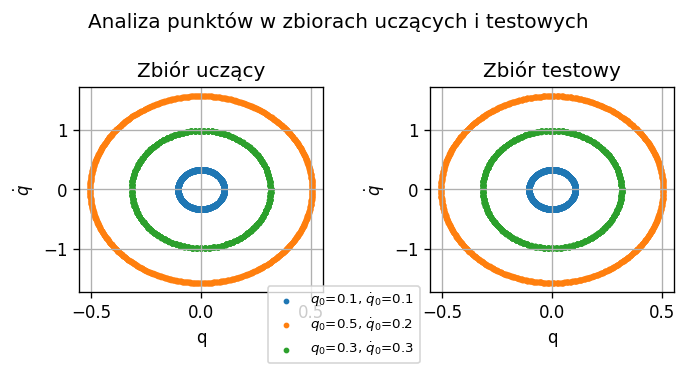

In [11]:
#BUDOWA ZBIORU UCZĄCEGO NA PODSTAWIE TRAJEKTORI WAHADŁA
N=1000

#Wektor punktów początkowych (3 warianty do testu)
x0 = jnp.array([[0.1,0.1], [0.5,0.2], [0.3, 0.3]], dtype=np.float32)

#Wektor czasów dla zbioru uczącego
t_train = np.arange(0,N, dtype=np.float32)
#Wektor czasów dla zbioru testowego
t_test = np.arange(N,2*N, dtype=np.float32)


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)

#Wyznaczenie 3 różnych zbiorów uczących na podstawie trajektori
#o różnych punktach startowych.
for i in range(x0.shape[0]):

    #Zbiór uczący
    x_train = jax.device_get(solve_analitical(x0[i], t_train))  #Dane wejściowe zbudowane na podstawie trajektori
    x_train = jax.device_get(jax.vmap(normalize)(x_train))      #Normalizacja danych wejściowych
    y_train = jax.device_get(jax.vmap(analitical)(x_train))     #Wyznaczenie danych wyjściowych (przyśpieszenie dla danych wektorów stanu [położenie, prędkość])

    #Zbiór testowy
    x_test = jax.device_get(solve_analitical(x_train[-1], t_train)) #Dane wejściowe zbudowane na podstawie trajektori
    x_test = jax.device_get(jax.vmap(normalize)(x_test))            #Normalizacja danych wejściowych
    y_test = jax.device_get(jax.vmap(analitical)(x_test))           #Wyznaczenie danych wyjściowych (przyśpieszenie dla danych wektorów stanu [położenie, prędkość])

    #Wyświetlenie wartość wejściowych na wykresie
    axes[0].scatter(x_train[:, 0], x_train[:, 1], s=6, alpha=1)
    axes[1].scatter(x_test[:, 0], x_test[:, 1], s=6, alpha=1)


#Wykres
fig.suptitle("Analiza punktów w zbiorach uczących i testowych")
axes[0].set_xlabel('q')
axes[0].set_ylabel('$\dot q$')
axes[0].set_title('Zbiór uczący')
axes[0].grid()
axes[1].set_xlabel('q')
axes[1].set_ylabel('$\dot q$')
axes[1].set_title('Zbiór testowy')
axes[1].grid()
fig.legend(['$q_0$=0.1, $\dot q_0$=0.1','$q_0$=0.5, $\dot q_0$=0.2', '$q_0$=0.3, $\dot q_0$=0.3'],fontsize="8", loc='lower center')
plt.tight_layout()



In [12]:
#BUDOWA ZBIORU UCZĄCEGO I TESTOWEGO NA PODSTAWIE WARTOŚCI LOSOWYCH

N=2500  #Liczność zbioru testowego i uczącego

#Maksymalne wartości prędkości w zbiorze
v_max=2*np.sqrt(9.81)

x_test_train = np.zeros([2*N, 2])
#Wyznaczenie losowych wartości położenia i prędkości 
x_test_train[:,0] = np.random.rand(N*2)*2*(np.pi) - (np.pi)  #Zakres wartości położenia <-Pi;Pi>
x_test_train[:,1] = np.random.rand(N*2)*2*v_max - v_max  #Zakres wartości <-Vmax;Vmax>
#Obliczenie wartości wyjściowych (przyśpieszenia) dla otrzymanych losowych punktów położenia i prędkości
#przy użyciu równania różniczkowego otrzymanego w sposób analityczny 
y_test_train = jax.device_get(jax.vmap(analitical)(x_test_train))

#Rozbicie zbioru na uczący i testowy
x_train = x_test_train[0:N]
y_train = y_test_train[0:N]

x_test = x_test_train[N:2*N]
y_test = y_test_train[N:2*N]

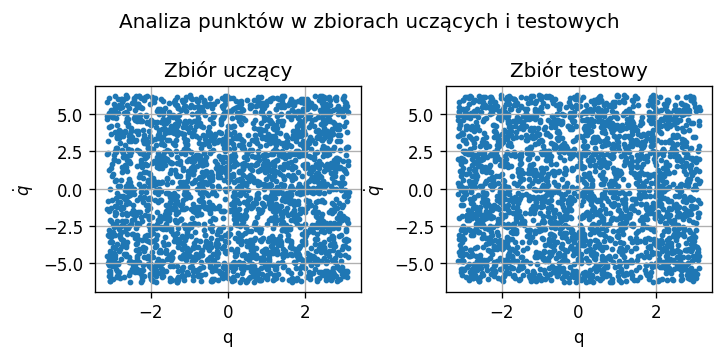

In [13]:
#WIZUALIZACJA ZBIORU DANYCH

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Analiza punktów w zbiorach uczących i testowych")
axes[0].scatter(x_train[:, 0], x_train[:, 1], s=6)
axes[0].set_xlabel('q')
axes[0].set_ylabel('$\dot q$')
axes[0].set_title('Zbiór uczący')
axes[0].grid()
axes[1].scatter(x_test[:, 0], x_test[:, 1], s=6)
axes[1].set_xlabel('q')
axes[1].set_ylabel('$\dot q$')
axes[1].set_title('Zbiór testowy')
axes[1].grid()
plt.tight_layout()

In [17]:
#ARCHITEKUTRA SIECI NEURONOWEJ
layers=[4,32,32,32,1]


class NeuralNetwork(nn.Module):
  input_size:int
  output_size:int
  hidden_layer:int
  layer_size:int
  
  def setup(self):
    
    kernel_init = nn.initializers.variance_scaling(scale=2.0, mode='fan_avg', distribution='truncated_normal')
    self.Dense = [nn.Dense(features=self.layer_size) for i in range(self.hidden_layer)]
    self.Output = nn.Dense(self.output_size)

 
  def __call__(self, x):
    for i in range(self.hidden_layer):
      x = self.Dense[i](x)
      x = nn.softplus(x)
    x = self.Output(x)
    return x
  
  def init_params(self, key):
    variables = self.init(key, jnp.ones((self.input_size)))
    return variables['params']
  
  def learned_lagrangian(self, params):
    def lagrangian(q, q_t):
        assert q.shape == (1,)
        state = jnp.concatenate([q, q_t])
        return jnp.squeeze(self.apply({'params': params}, state), axis=-1)
    return lagrangian
  


def MSE_loss(train_state, params, state, targets):
  preds = jax.vmap(partial(equation_of_motion, train_state.apply_fn(params)))(state)
  return jnp.mean((preds - targets) ** 2)


@jax.jit  
def train_step(train_state, state, targets):
    
    grad_fn = jax.value_and_grad(MSE_loss, argnums=1)
    
    loss, grads = grad_fn(train_state, train_state.params, state, targets)
    
    train_state = train_state.apply_gradients(grads=grads)
    
    return train_state, loss
  


def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [18]:
%%time

Training = True    
Epochs = 10000      
StopError = 0.001  
learning_rate = 1e-2
batch_size = 64

train_error = []   
test_error = []    

model = NeuralNetwork(input_size=2, output_size=1, hidden_layer=2, layer_size=64)
rng = jax.random.PRNGKey(0)
params_initial = model.init_params(rng)


optimizer = optax.adam(learning_rate=learning_rate)
model_state = train_state.TrainState.create(apply_fn=model.learned_lagrangian,
                                            params=params_initial,
                                            tx=optimizer)


ckpt_dir = os.path.abspath('Checkpoints')



if Training:
    x_train, x_test, y_train, y_test = map(jax.device_get, [x_train, x_test, y_train, y_test])
    n_samples =  x_train.shape[0]

    best_error = float('inf')

    for i in range(Epochs):
        
        x_train, y_train = shuffle(x_train, y_train)
        start = 0
        loss = 0
        full_batch = 0
        
        while start < n_samples:
            end = start + batch_size
            x_batch = x_train[start:end, :]
            y_batch = y_train[start:end, :]

            
            model_state, act_loss = train_step(model_state, x_batch, y_batch)
            loss += act_loss
            start += batch_size

        
        train_error.append(loss / (float(start+batch_size) /  float(batch_size)))
        test_error.append(MSE_loss(model_state, model_state.params, x_test, y_test))

        
        if test_error[-1] < best_error:
            best_error = test_error[-1]
            best_params = model_state.params

        
        if test_error[-1] <= StopError:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
            break

        
        if i % 1 == 0:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")

   
    params = best_params
    checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,  # Folder to save checkpoint in
                            target=model_state,  # What to save. To only save parameters, use model_state.params
                            step=len(test_error),  # Training step or other metric to save best model on
                            prefix='pojedyncze_wahadlo',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )
else:
    loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir=ckpt_dir,   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='pojedyncze_wahadlo'  # Checkpoint file name prefix
                                            )
    params = model_state.params
    

iteration=0, train_loss=1910.776489, test_loss=95.526917, best_loss=95.526917
iteration=1, train_loss=92.786743, test_loss=94.403648, best_loss=94.403648
iteration=2, train_loss=92.416290, test_loss=93.255737, best_loss=93.255737
iteration=3, train_loss=90.892975, test_loss=91.956238, best_loss=91.956238
iteration=4, train_loss=93.640678, test_loss=90.561569, best_loss=90.561569
iteration=5, train_loss=89.304947, test_loss=89.043701, best_loss=89.043701
iteration=6, train_loss=89.308662, test_loss=87.513931, best_loss=87.513931
iteration=7, train_loss=84.588249, test_loss=85.945663, best_loss=85.945663
iteration=8, train_loss=83.708916, test_loss=84.426651, best_loss=84.426651
iteration=9, train_loss=82.556732, test_loss=82.885666, best_loss=82.885666
iteration=10, train_loss=81.416458, test_loss=81.382584, best_loss=81.382584
iteration=11, train_loss=79.094727, test_loss=79.870651, best_loss=79.870651
iteration=12, train_loss=77.494919, test_loss=78.363533, best_loss=78.363533
iterati

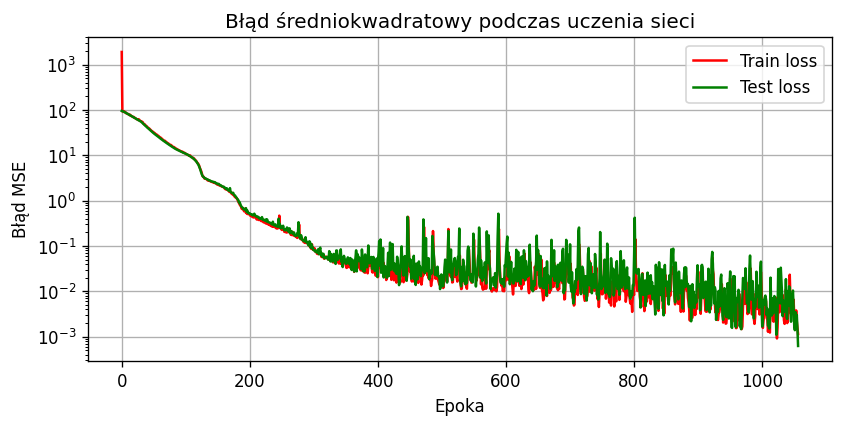

In [19]:
#WIZUALIZACJA BŁĘDU MSE PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[:], 'r', label='Train loss')
plt.plot(test_error[:], 'g', label='Test loss')
plt.yscale('log')
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend() 
plt.show()

In [21]:
#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu zamodlowanego za pomocą sieci neuronowej
#Argumenty funkcji:
#   -params        - Parametry sieci neuronowej
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_lagrangian(model, params, initial_state, times):
  return odeint(partial(equation_of_motion, model.learned_lagrangian(params)),
                  initial_state, times, rtol=1e-10, atol=1e-10)
  
  
#Funkcja ma za zadanie obliczenie przyśpieszenia na podstawie aktualnego stanu
#(położenie i przyśpieszenie) przy użyciu lagrangianu zamodelowanego przez sieć LNN.
#Argumenty funkcji:
#   -params     - Parametry sieci.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości [q, q_t].
#Zwracane:  Przyśpieszenie wynikającego z aktulanego wektora stanu.  
@partial(jax.jit, backend='cpu')
def acceleration_learned(model, params, initial_state):
  acc = partial(equation_of_motion, model.learned_lagrangian(params))
  return acc(initial_state)[1]

In [22]:
#TEST PREDYKCJI SIECI

#Obliczenie predykcji sieci (wartość wyjściowa) na podstawie zbioru testowego
y_pred = jax.vmap(partial(equation_of_motion, acceleration_learned(model, params, x_test)))

#Wizualizacji wyników
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=1)
axes[0].set_xlabel('oczkiwane $\dot q$')
axes[0].set_ylabel('predykcja $\dot q$')
axes[0].grid()
axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=6, alpha=1)
axes[1].set_xlabel('oczkiwane $\ddot q$')
axes[1].set_ylabel('predykcja $\ddot q$')
axes[1].grid()
plt.tight_layout()



TypeError: Error interpreting argument to <function acceleration_learned at 0x7fde1c9dc9d0> as an abstract array. The problematic value is of type <class '__main__.NeuralNetwork'> and was passed to the function at path model.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [18]:
#OBLICZENIE BŁĘDU WZGLĘDNEGO PREDYKCJI

#Zakresy prędkości i położenia
q=jnp.arange(-1*np.pi, np.pi, 0.2, dtype=jnp.float32)
q = np.concatenate([q, jnp.array([np.pi])])
q_t=jnp.arange(-1*v_max, v_max, 0.5, dtype=jnp.float32)
q_t = np.concatenate([q_t, jnp.array([v_max])])



True_value = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Pred_value = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Error = np.zeros([len(q), len(q_t)],dtype=jnp.float32)



for i in range (len(q)):
    for j in range(len(q_t)):
        True_value[i,j] = analitical(jnp.array([q[i], q_t[j]]))[1]                #Wartość rzczywista
        Pred_value[i,j] = acceleration_learned(params, jnp.array([q[i], q_t[j]]))           #Predykcja
        Error[i,j] = np.abs(True_value[i,j]-Pred_value[i,j])/np.abs(True_value[i,j])*100    #Błąd (wartość bezwlędna z różnicy)


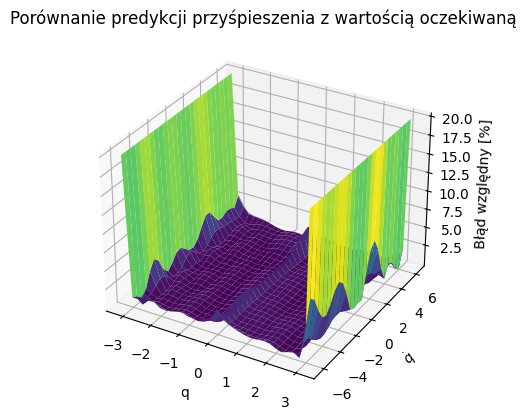

<Figure size 640x480 with 0 Axes>

In [19]:
#WIZUALIZACJA WZGLĘDNEGO BŁĘDU PROCENTOWEGO PREDYKCJI

q, q_t = np.meshgrid(q, q_t)
Error = np.transpose(Error)

Error = np.where(Error>20, 20, Error)

#Wizualizacja
#%matplotlib qt5
fig = plt.figure()
axes = fig.add_subplot(projection='3d')

axes.set_title("Porównanie predykcji przyśpieszenia z wartością oczekiwaną")
axes.set_xlabel('q')
axes.set_ylabel('$\dot q$')
axes.set_zlabel("Błąd względny [%]")
axes.grid()

axes.plot_surface(q, q_t, Error, cmap='viridis')
plt.show()
plt.tight_layout()
%matplotlib inline

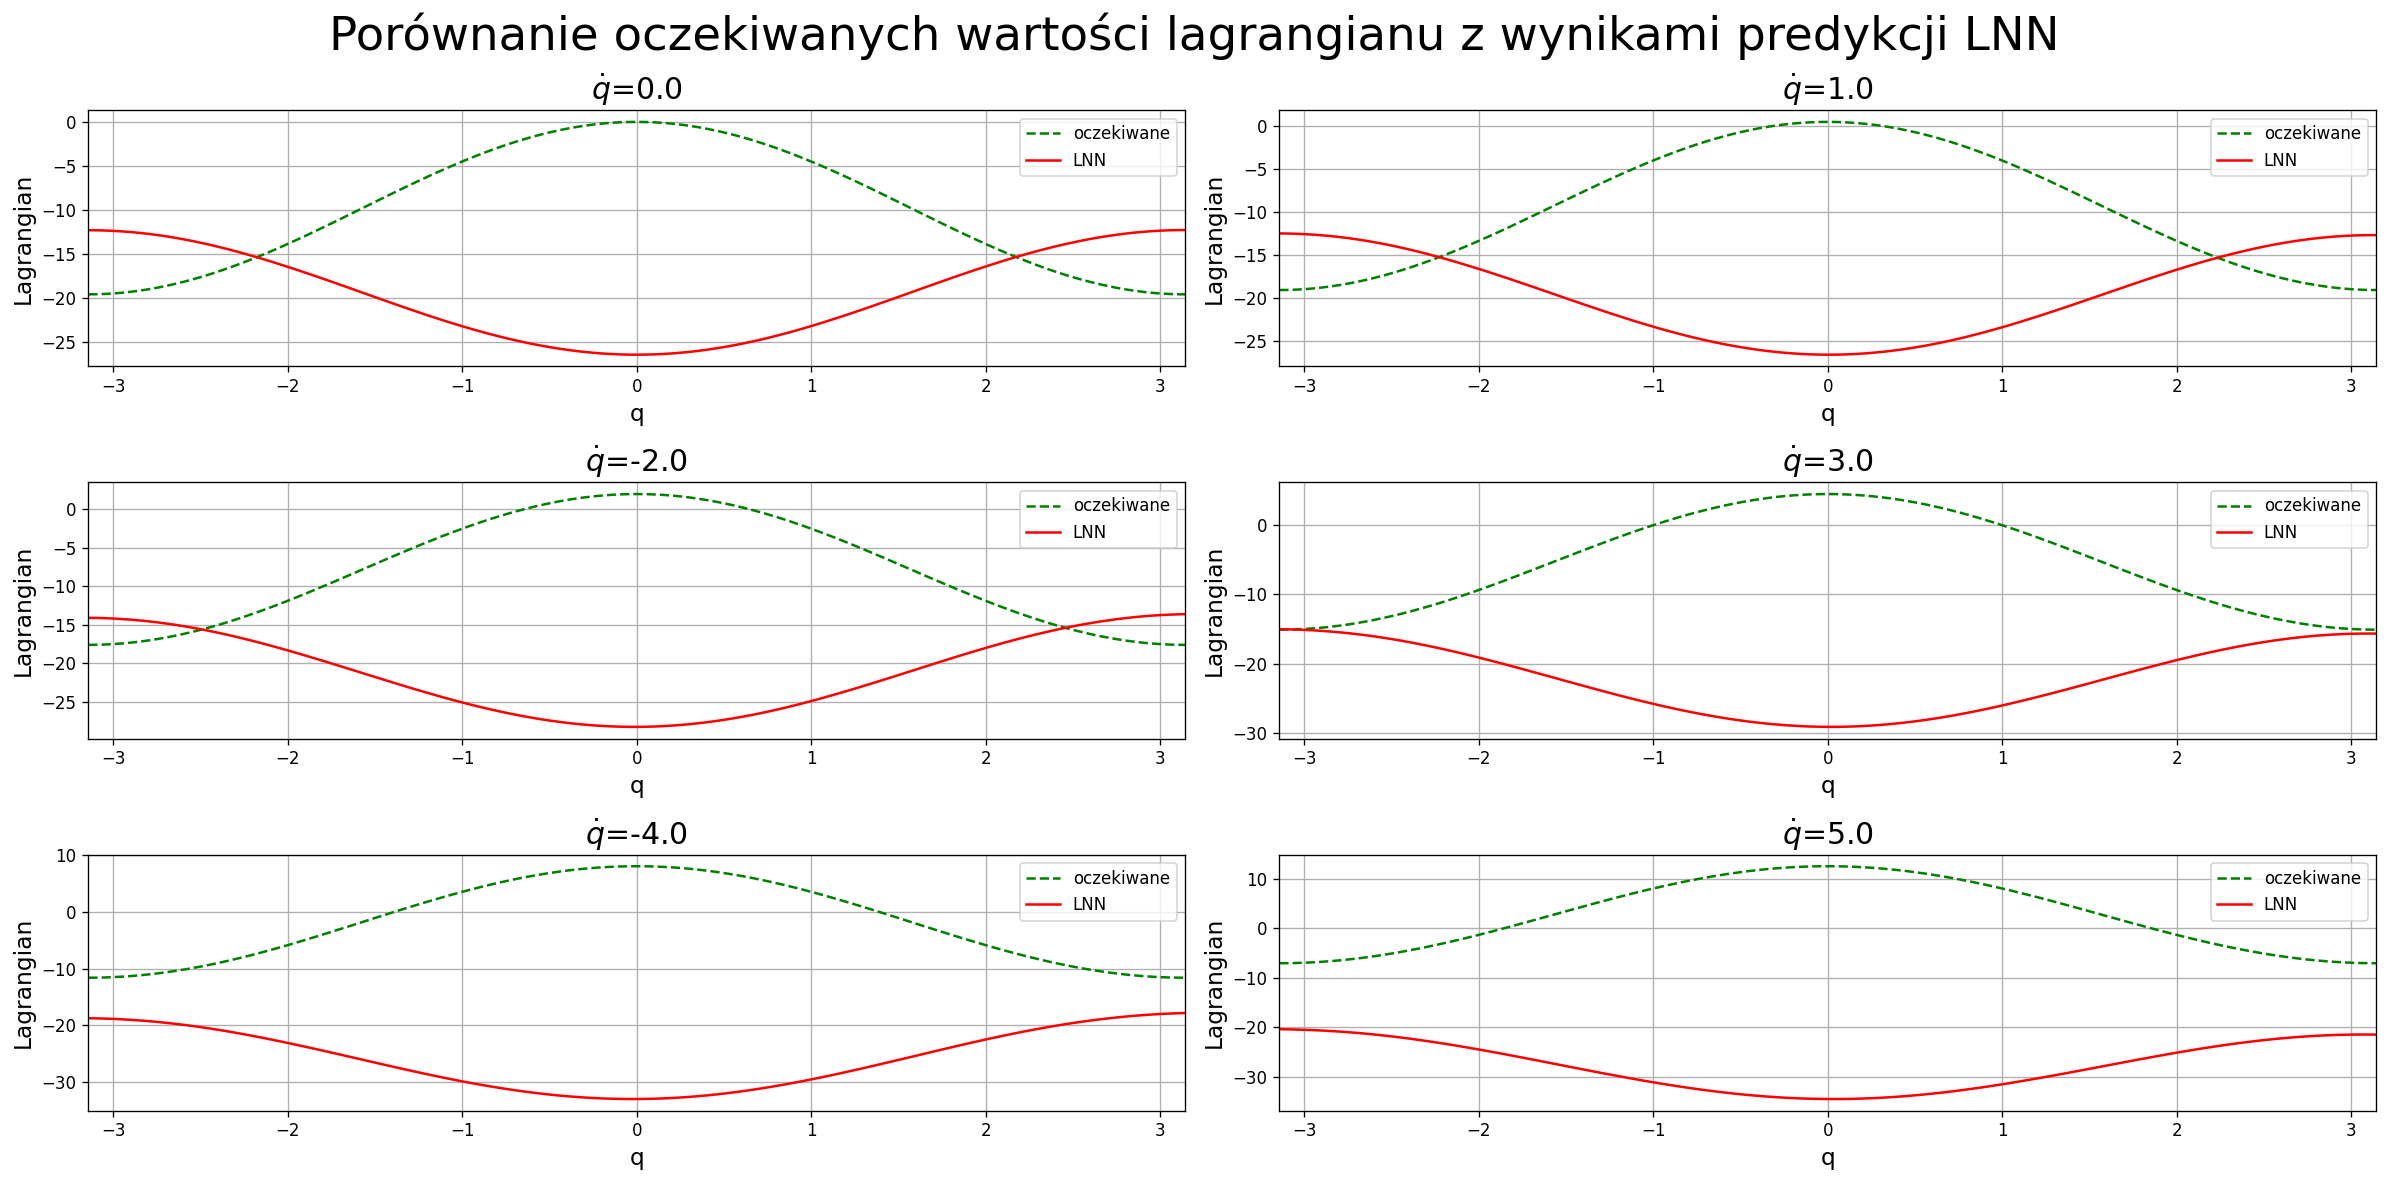

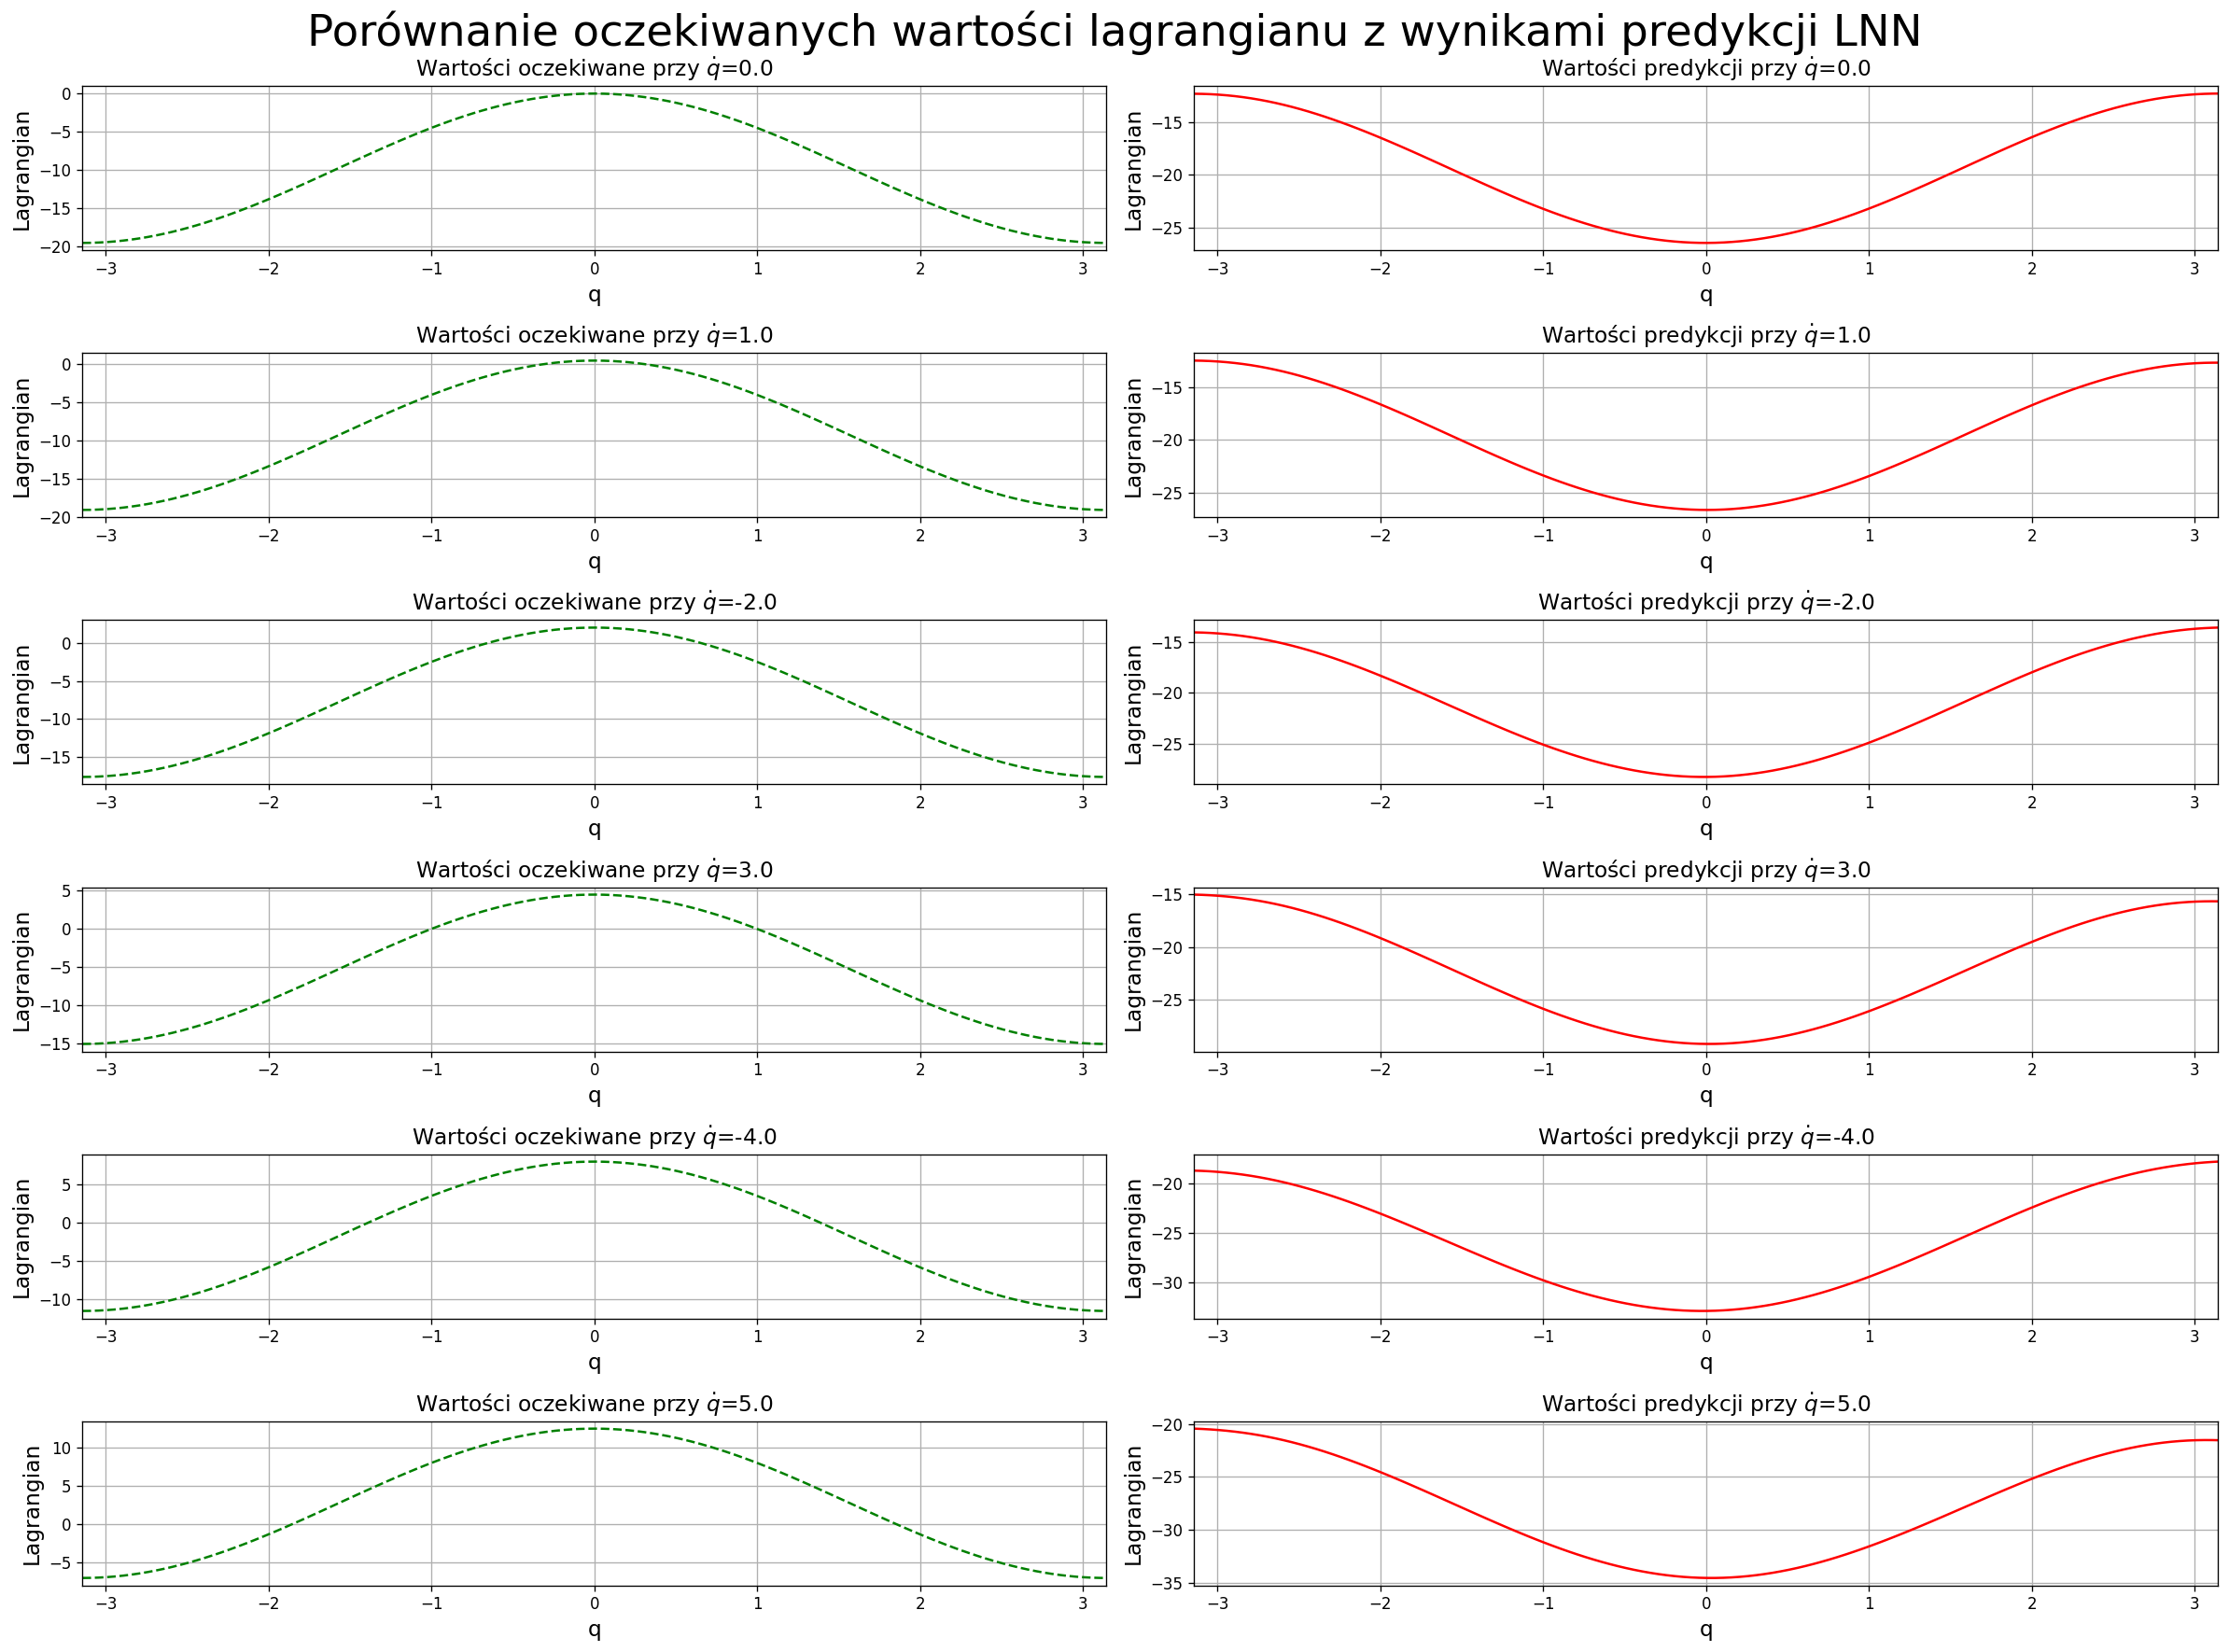

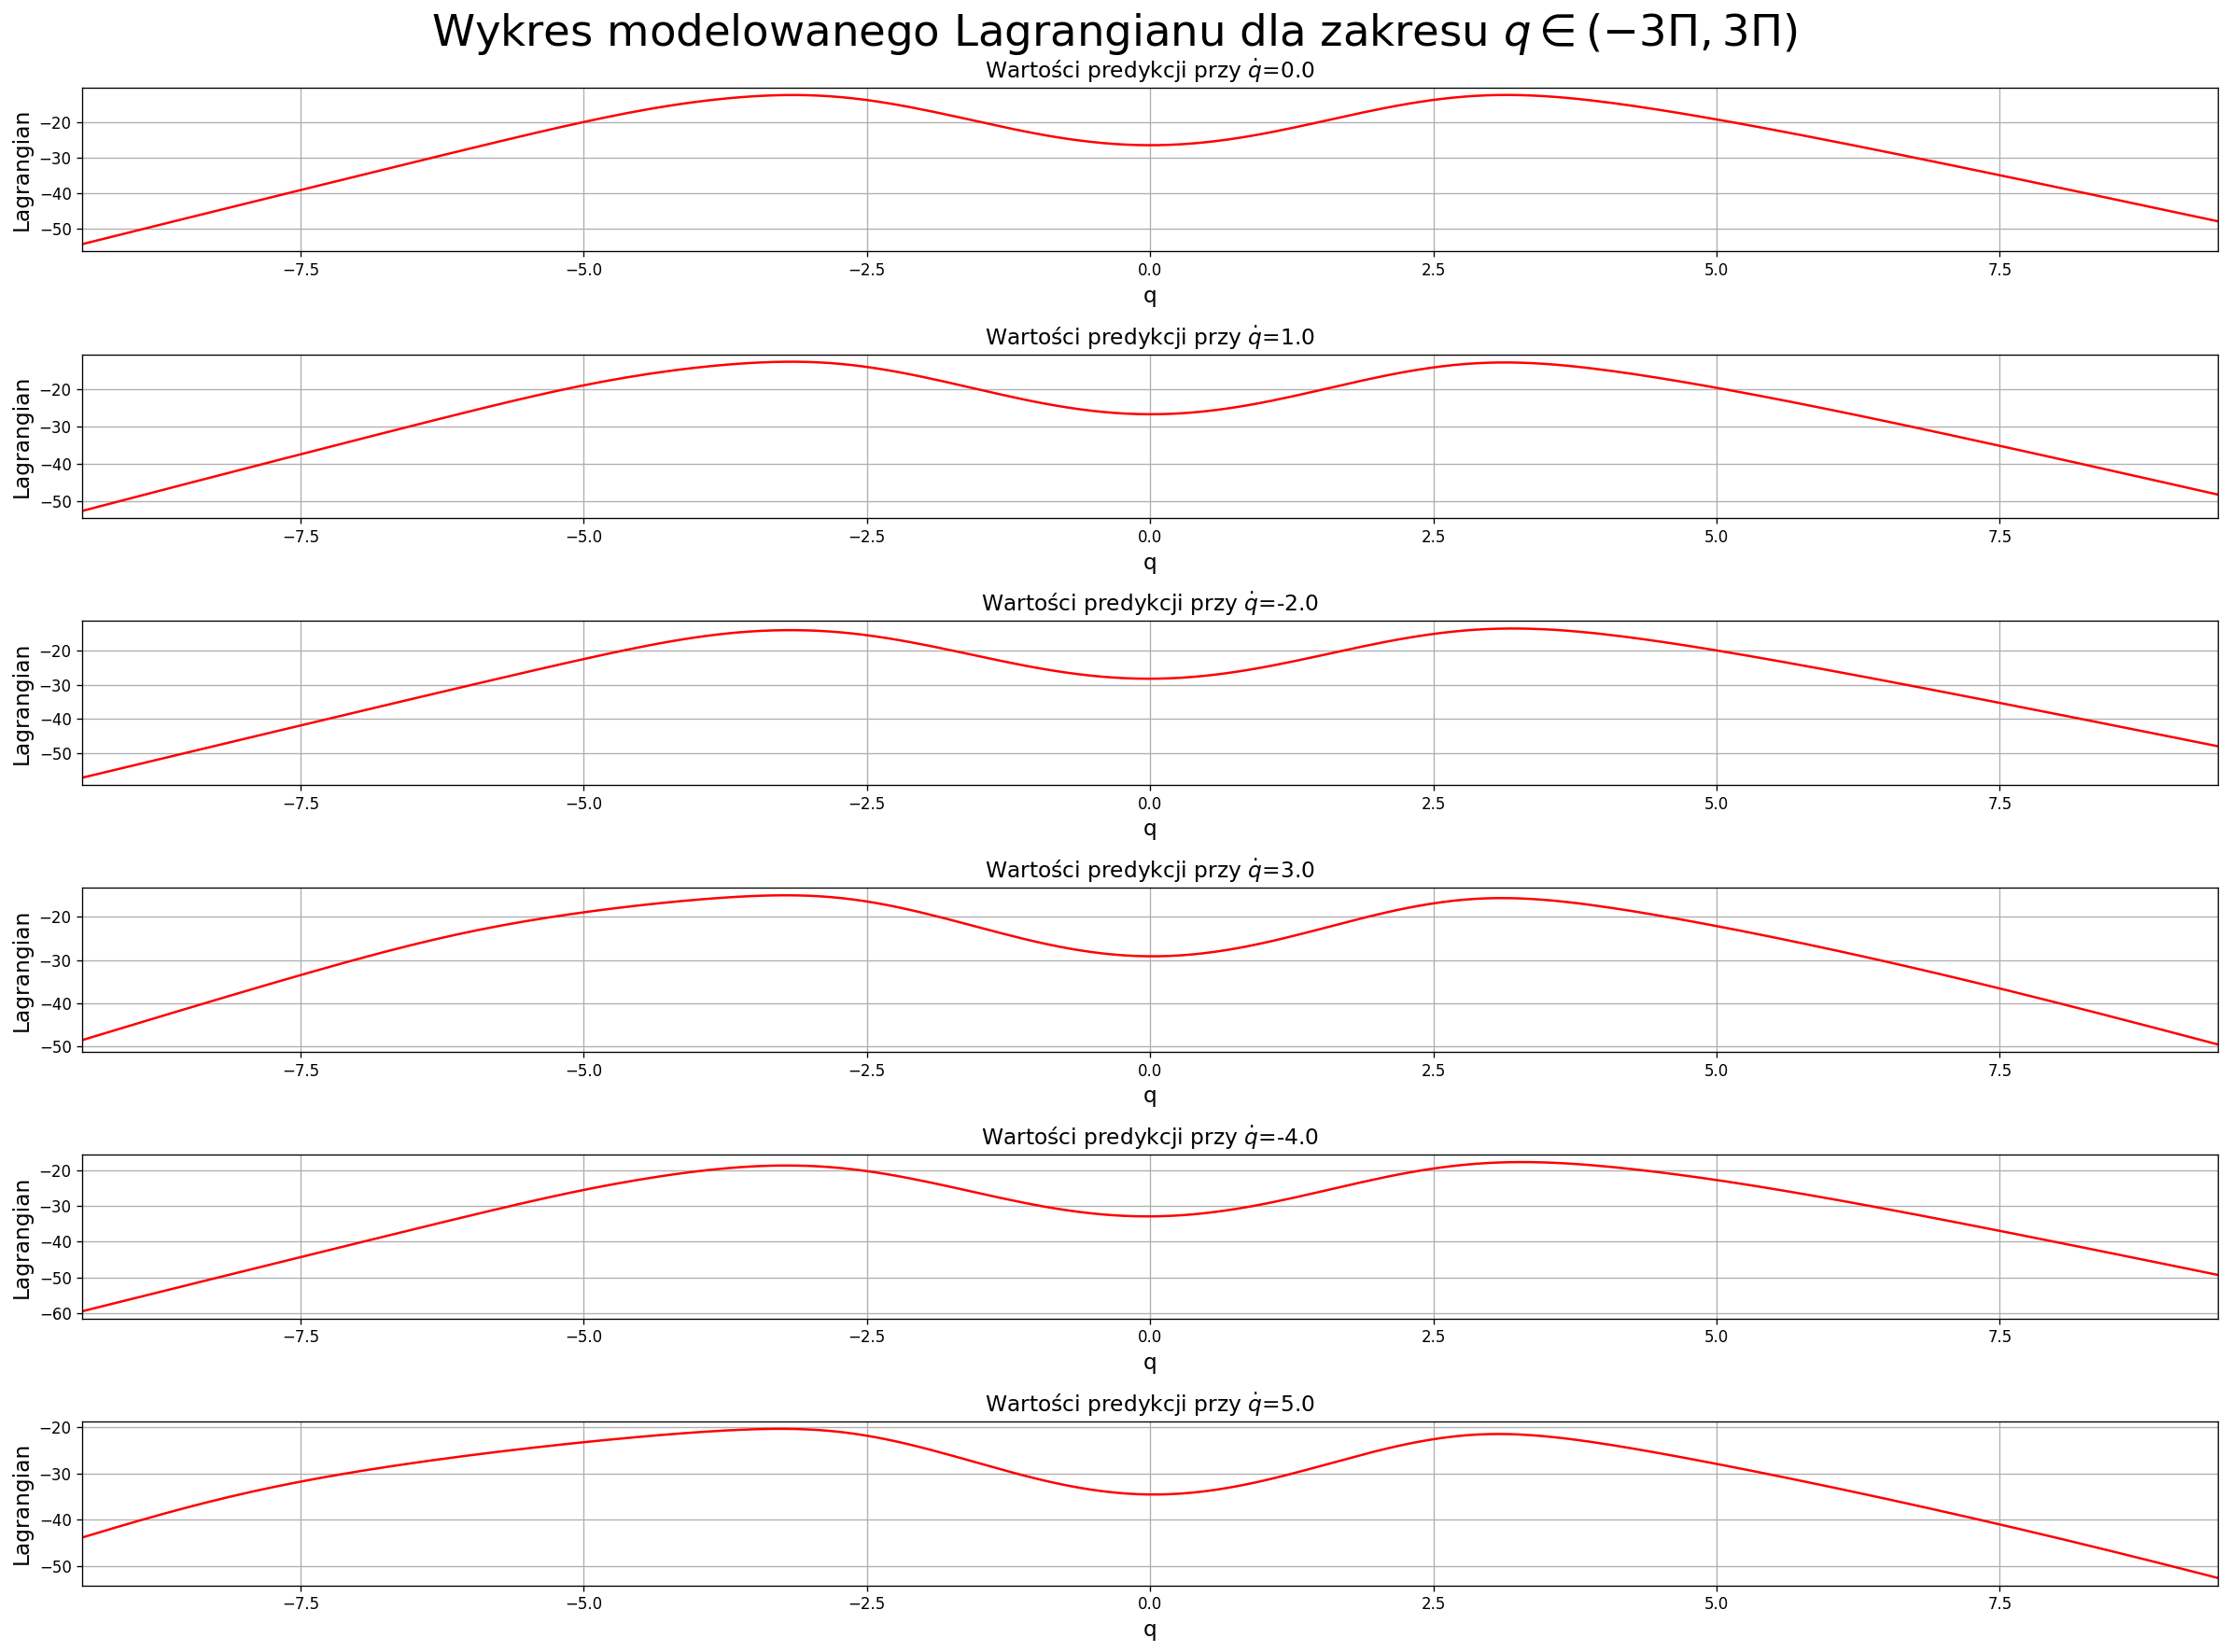

In [20]:
q=jnp.arange(-1*np.pi, np.pi, 0.05, dtype=jnp.float32)
q = jnp.concatenate([q, jnp.array([np.pi], dtype=jnp.float32)])
q_t=jnp.array([0,1,-2,3,-4,5], dtype=jnp.float32)

q=jax.device_get(q)
q_t=jax.device_get(q_t)

Lagrangian_true = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Lagrangian_pred = np.zeros([len(q), len(q_t)],dtype=jnp.float32)

for i in range (len(q)):
    for j in range(len(q_t)):
        Lagrangian_true[i,j] = jax.device_get(lagrangian_analitical(q[i], q_t[j], 1, 1, 9.8)).item()                #Wartość rzeczywista
        Lagrangian_pred[i,j] = jax.device_get(learned_lagrangian(params)(jnp.array([q[i]]), jnp.array([q_t[j]])))   #Predykcja




#WIZUALIZACJA
fig, axes = plt.subplots(3, 2, figsize=(20, 10), dpi=120)
for i, ax in enumerate(axes.flat):
    ax.plot(q, Lagrangian_true[:, i], 'g--', label='oczekiwane')
    ax.plot(q, Lagrangian_pred[:, i], 'r', label='LNN')
    ax.set_xlim(-1*np.pi, np.pi)
    ax.set_xlabel('q', fontsize=14)
    ax.set_ylabel('Lagrangian', fontsize=14)
    ax.set_title('$\dot q$='+str(q_t[i]), fontsize=18)
    ax.legend()
    ax.grid()
    
fig.suptitle('Porównanie oczekiwanych wartości lagrangianu z wynikami predykcji LNN', fontsize=28)


plt.tight_layout()


#Wizualizacji wyników
fig1, axes1 = plt.subplots(6, 2, figsize=(20, 15), dpi=120)

for i in range(len(q_t)):
    axes1[i,0].plot(q, Lagrangian_true[:, i],'g--')
    axes1[i,0].set_ylabel('Lagrangian', fontsize=14)
    axes1[i,0].set_xlabel('q', fontsize=14)
    axes1[i,0].set_title('Wartości oczekiwane przy $\dot q$='+str(q_t[i]), fontsize=14)
    axes1[i,0].grid()
    axes1[i,0].set_xlim(-1*np.pi, np.pi)
    axes1[i,1].plot(q, Lagrangian_pred[:, i],'r')
    axes1[i,1].set_ylabel('Lagrangian', fontsize=14)
    axes1[i,1].set_xlabel('q', fontsize=14)
    axes1[i,1].set_title('Wartości predykcji przy $\dot q$='+str(q_t[i]), fontsize=14)
    axes1[i,1].grid()
    axes1[i,1].set_xlim(-1*np.pi, np.pi)

fig1.suptitle('Porównanie oczekiwanych wartości lagrangianu z wynikami predykcji LNN', fontsize=28)
plt.tight_layout()



q_p=jnp.arange(-3*np.pi, 3*np.pi, 0.1, dtype=jnp.float32)
q_p = jnp.concatenate([q_p, jnp.array([3*np.pi], dtype=jnp.float32)])

q_p=jax.device_get(q_p)

Lagrangian_pred_p = np.zeros([len(q_p), len(q_t)],dtype=jnp.float32)

for i in range (len(q_p)):
    for j in range(len(q_t)):
        Lagrangian_pred_p[i,j] = jax.device_get(learned_lagrangian(params)(jnp.array([q_p[i]]), jnp.array([q_t[j]])))   #Predykcja




fig2, axes2 = plt.subplots(6, 1, figsize=(20, 15), dpi=120)


for i in range(len(q_t)):
    axes2[i].plot(q_p, Lagrangian_pred_p[:, i],'r')
    axes2[i].set_ylabel('Lagrangian', fontsize=14)
    axes2[i].set_xlabel('q', fontsize=14)
    axes2[i].set_title('Wartości predykcji przy $\dot q$='+str(q_t[i]), fontsize=14)
    axes2[i].grid()
    axes2[i].set_xlim(-3*np.pi, 3*np.pi)

fig2.suptitle('Wykres modelowanego Lagrangianu dla zakresu $q\in(-3\Pi, 3\Pi)$', fontsize=28)
plt.tight_layout()





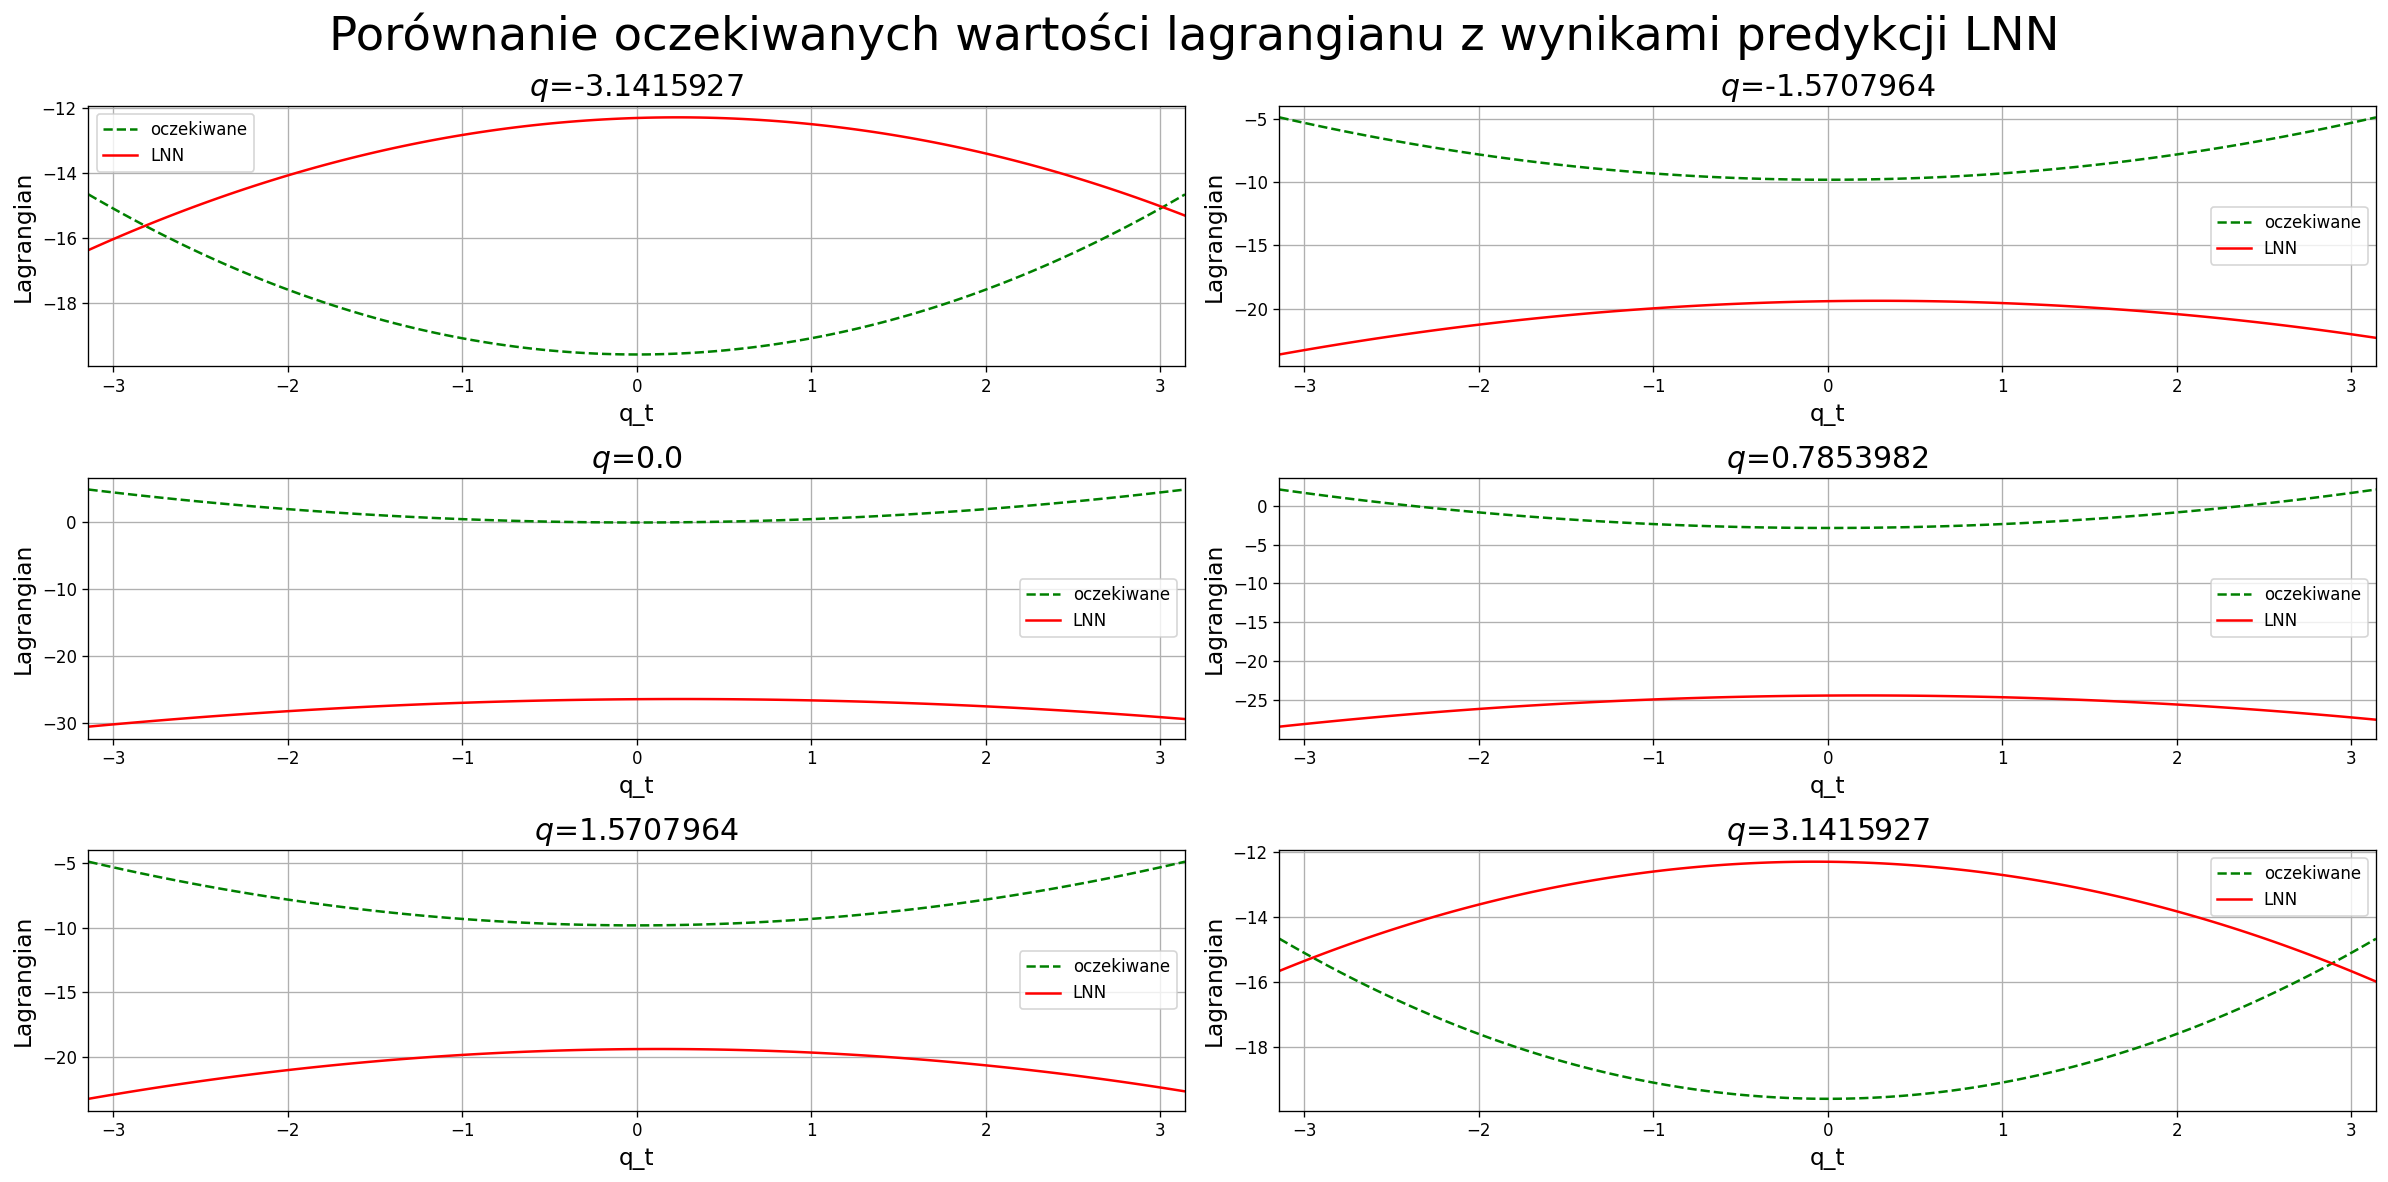

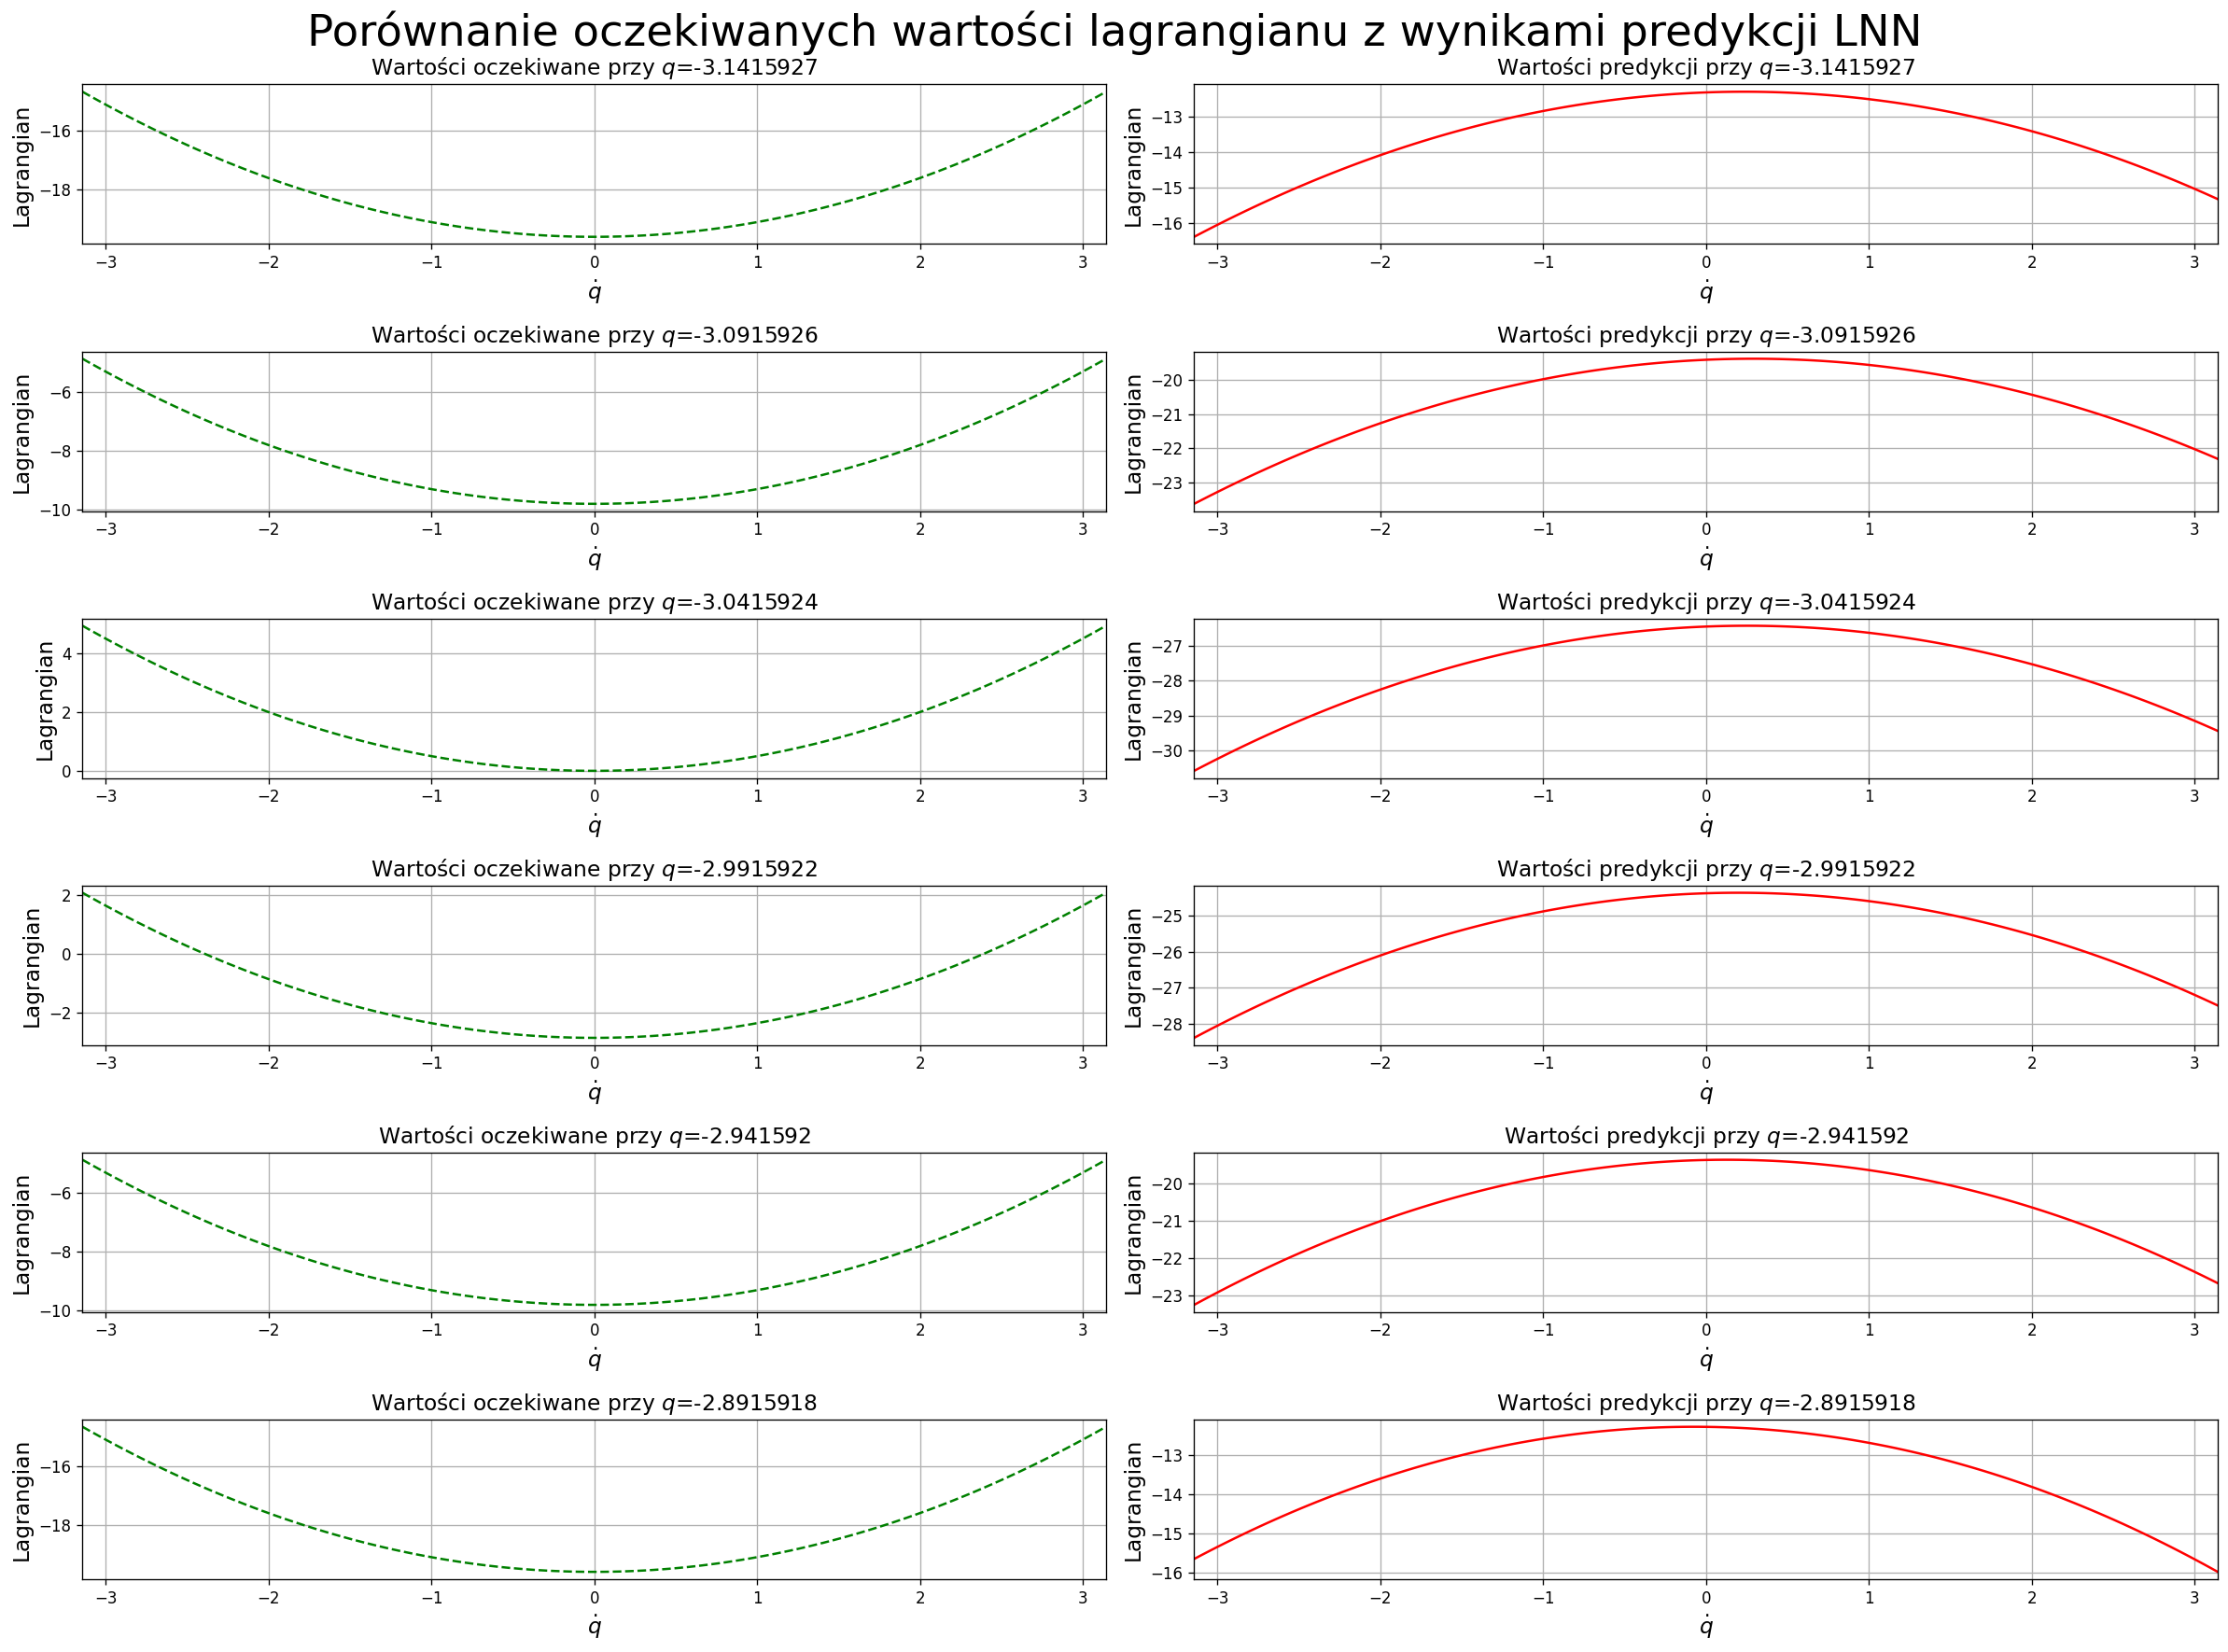

In [21]:
q_t=jnp.arange(-1*np.pi, np.pi, 0.05, dtype=jnp.float32)
q_t = jnp.concatenate([q_t, jnp.array([np.pi], dtype=jnp.float32)])
q=jnp.array([-np.pi, -np.pi/2, 0, np.pi/4, np.pi/2, np.pi], dtype=jnp.float32)

q=jax.device_get(q)
q_t=jax.device_get(q_t)

Lagrangian_true = np.zeros([len(q_t), len(q)],dtype=jnp.float32)
Lagrangian_pred = np.zeros([len(q_t), len(q)],dtype=jnp.float32)

for i in range (len(q_t)):
    for j in range(len(q)):
        Lagrangian_true[i,j] = jax.device_get(lagrangian_analitical(q[j], q_t[i], 1, 1, 9.8)).item()                #Wartość rzeczywista
        Lagrangian_pred[i,j] = jax.device_get(learned_lagrangian(params)(jnp.array([q[j]]), jnp.array([q_t[i]])))   #Predykcja




#WIZUALIZACJA
fig, axes = plt.subplots(3, 2, figsize=(20, 10), dpi=120)
for i, ax in enumerate(axes.flat):
    ax.plot(q_t, Lagrangian_true[:, i], 'g--', label='oczekiwane')
    ax.plot(q_t, Lagrangian_pred[:, i], 'r', label='LNN')
    ax.set_xlim(-1*np.pi, np.pi)
    ax.set_xlabel('q_t', fontsize=14)
    ax.set_ylabel('Lagrangian', fontsize=14)
    ax.set_title('$q$='+str(q[i]), fontsize=18)
    ax.legend()
    ax.grid()
    
fig.suptitle('Porównanie oczekiwanych wartości lagrangianu z wynikami predykcji LNN', fontsize=28)


plt.tight_layout()


#Wizualizacji wyników
fig1, axes1 = plt.subplots(6, 2, figsize=(20, 15), dpi=120)

for i in range(len(q)):
    axes1[i,0].plot(q_t, Lagrangian_true[:, i],'g--')
    axes1[i,0].set_ylabel('Lagrangian', fontsize=14)
    axes1[i,0].set_xlabel('$\dot q$', fontsize=14)
    axes1[i,0].set_title('Wartości oczekiwane przy $q$='+str(q_t[i]), fontsize=14)
    axes1[i,0].grid()
    axes1[i,0].set_xlim(-1*np.pi, np.pi)
    axes1[i,1].plot(q_t, Lagrangian_pred[:, i],'r')
    axes1[i,1].set_ylabel('Lagrangian', fontsize=14)
    axes1[i,1].set_xlabel('$\dot q$', fontsize=14)
    axes1[i,1].set_title('Wartości predykcji przy $q$='+str(q_t[i]), fontsize=14)
    axes1[i,1].grid()
    axes1[i,1].set_xlim(-1*np.pi, np.pi)

fig1.suptitle('Porównanie oczekiwanych wartości lagrangianu z wynikami predykcji LNN', fontsize=28)
plt.tight_layout()


In [26]:
#TEST WYZNACZENIA TRAJEKTORI RUCHU PRZY UŻYCIU SIECI NEURONOWEJ

def normalize(state):
    dim = int(len(state)/2)
    return jnp.concatenate([(state[:dim] + np.pi) % (2 * np.pi) - np.pi, state[dim:]])


#Punkt startowy
x0 = jnp.array([np.pi,0], dtype=np.float32)
#Wektor czasu
t = np.linspace(0, 40, num=401, dtype=np.float32)

#Wyznaczenie trajektori przy użyciu sieci
%time lagrangian_trajectory = jax.device_get(solve_lagrangian(params, x0, t))
lagrangian_trajectory = jax.device_get(jax.vmap(normalize)(lagrangian_trajectory))

#Wyznaczenie trajektori metodą analityczną
%time analitical_trajectory = jax.device_get(solve_analitical(x0, t))


#WIZUALIZACJA
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektorii ruchu otrzymanych przy użyciu metody analitycznej i LNN')


axes[0].plot(t, analitical_trajectory[:, 0], 'r', label='analityczne')
axes[0].plot(t, lagrangian_trajectory[:, 0], 'g--', label='LNN')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()
#axes[0].axis([0,t[-1],-1*np.pi,np.pi])


axes[1].plot(t, analitical_trajectory[:, 1], 'r', label='analityczne')
axes[1].plot(t, lagrangian_trajectory[:, 1], 'g--', label='LNN')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

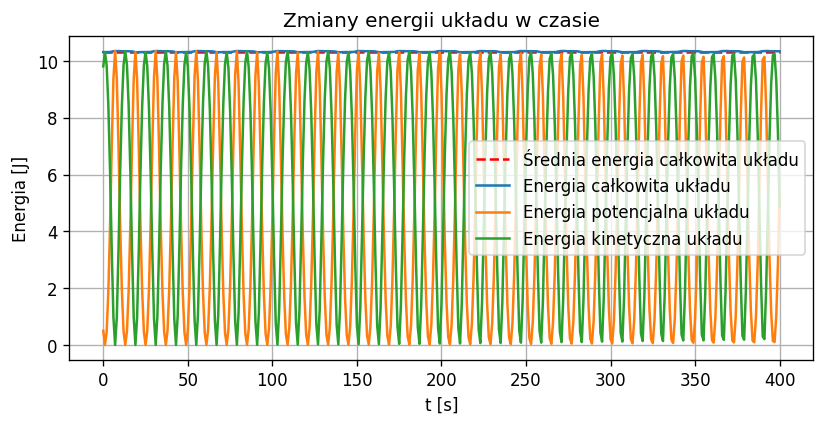

In [23]:
#Wyznaczenie Energi potencjalnej i kinetycznej trajektorii

q, q_t = jnp.hsplit(lagrangian_trajectory, 2)
energy = partial(compute_energy, m=1, l=1, g=9.81)
Ep, Ek = jax.vmap(energy)(q, q_t)
Ec=Ep+Ek
mean = jnp.mean(Ec)
mean_Ec = jnp.ones(Ec.shape, dtype=jnp.float32) * jnp.mean(Ec)

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(mean_Ec, 'r--', label="Średnia energia całkowita układu")
plt.plot(Ec, label="Energia całkowita układu")
plt.plot(Ep, label="Energia potencjalna układu")
plt.plot(Ek, label="Energia kinetyczna układu")
plt.title('Zmiany energii układu w czasie')
plt.xlabel("t [s]") 
plt.ylabel("Energia [J]")
plt.legend()
plt.grid()
plt.show()